# Setup

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, regularizers, backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dropout
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import glob

### load data

In [2]:
# Load array
x_train = np.load('driven_damped_pendulum_data_train.npy')
x_val = np.load('driven_damped_pendulum_data_valid.npy')
x_test = np.load('driven_damped_pendulum_data_test.npy')

kappas_tr, betas_tr, As_tr, omegas_tr = np.loadtxt('driven_damped_pendulum_data_params_train.dat', unpack=True)
kappas_va, betas_va, As_va, omegas_va = np.loadtxt('driven_damped_pendulum_data_params_valid.dat', unpack=True)
kappas_te, betas_te, As_te, omegas_te = np.loadtxt('driven_damped_pendulum_data_params_test.dat', unpack=True)

In [3]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Neural Network

In [33]:
num_hidden_layers = 2
encoding_dim = 5
input_dim = x_train.shape[1]
hidden_dim = 100
batch_size = 512
epochs = 1000
learning_rate = 0.0001
regul=0.01
regul2=0.01

factor = 0.25
patience = 50
min_lr = 0.000001
verbose = 1

In [34]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='total_loss',
                                                 factor=factor,
                                                 patience=patience, 
                                                 min_lr=min_lr, 
                                                 verbose=verbose
                                                )

In [35]:
early_stopping_callback = EarlyStopping(
    patience=patience,
    monitor='total_loss',
    mode='min',
    verbose=verbose
)

## Autoencoder

In [36]:
# Autoencoder
encoder_input = keras.Input(shape=(input_dim,))

# Encoder
x = layers.Dense(5 * hidden_dim, activation='relu', activity_regularizer=regularizers.L1(regul2))(encoder_input)
for i in range(num_hidden_layers):
    x = layers.Dense(hidden_dim, activation='relu', activity_regularizer=regularizers.L1(regul2))(x)
z_mean = layers.Dense(encoding_dim, activity_regularizer=regularizers.L1(regul))(x)
z_log_var = layers.Dense(encoding_dim, activity_regularizer=regularizers.L1(regul))(x)

z = Sampling()([z_mean, z_log_var])

# Decoder
decoder_input = keras.Input(shape=(encoding_dim,))
x = layers.Dense(hidden_dim, activation='relu', activity_regularizer=regularizers.L1(regul2))(decoder_input)
for i in range(num_hidden_layers):
    x = layers.Dense(hidden_dim, activation='relu', activity_regularizer=regularizers.L1(regul2))(x)
x = layers.Dense(5 * hidden_dim, activation='relu', activity_regularizer=regularizers.L1(regul2))(x)
decoded = layers.Dense(input_dim, activation='linear')(x)

# Define models
encoder = keras.Model(encoder_input, [z_mean, z_log_var, z], name='encoder')
decoder = keras.Model(decoder_input, decoded, name='decoder')
autoencoder = keras.Model(encoder_input, decoder(encoder(encoder_input)))

In [37]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name='total_loss')
        self.reconstruction_loss_tracker = keras.metrics.Mean(name='recon_loss')
        self.kl_loss_tracker = keras.metrics.Mean(name='kl_loss')

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            recon_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mse(data, reconstruction),
                    axis=(-1))) 
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = (recon_loss) + kl_loss
            grads = tape.gradient(total_loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
            self.total_loss_tracker.update_state(total_loss)
            self.reconstruction_loss_tracker.update_state(recon_loss)
            self.kl_loss_tracker.update_state(kl_loss)
            return {
                "total_loss": self.total_loss_tracker.result(),
                "recon_loss": self.reconstruction_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result(),
            }
    
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        z = self.sampler([z_mean, z_log_var])
        return self.decoder(z)

In [38]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), run_eagerly=True)

## training the model

In [39]:
fitting_output = vae.fit(x_train,
                          epochs=epochs,
                          batch_size=batch_size,
                          callbacks=[reduce_lr, early_stopping_callback])

Epoch 1/1000
28/28 [==============================] - 4s 149ms/step - total_loss: 123.9753 - recon_loss: 123.9023 - kl_loss: 0.0731 - lr: 1.0000e-04
Epoch 2/1000
28/28 [==============================] - 4s 152ms/step - total_loss: 110.1667 - recon_loss: 109.9532 - kl_loss: 0.2135 - lr: 1.0000e-04
Epoch 3/1000
28/28 [==============================] - 9s 328ms/step - total_loss: 99.4189 - recon_loss: 98.5948 - kl_loss: 0.8241 - lr: 1.0000e-04
Epoch 4/1000
28/28 [==============================] - 4s 150ms/step - total_loss: 89.7441 - recon_loss: 87.5160 - kl_loss: 2.2281 - lr: 1.0000e-04
Epoch 5/1000
28/28 [==============================] - 4s 133ms/step - total_loss: 77.8058 - recon_loss: 73.5348 - kl_loss: 4.2710 - lr: 1.0000e-04
Epoch 6/1000
28/28 [==============================] - 4s 125ms/step - total_loss: 65.1629 - recon_loss: 58.8426 - kl_loss: 6.3204 - lr: 1.0000e-04
Epoch 7/1000
28/28 [==============================] - 4s 156ms/step - total_loss: 53.8392 - recon_loss: 46.4500 - 

28/28 [==============================] - 5s 164ms/step - total_loss: 14.8465 - recon_loss: 6.5571 - kl_loss: 8.2894 - lr: 1.0000e-04
Epoch 57/1000
28/28 [==============================] - 5s 168ms/step - total_loss: 14.6213 - recon_loss: 6.3192 - kl_loss: 8.3020 - lr: 1.0000e-04
Epoch 58/1000
28/28 [==============================] - 4s 152ms/step - total_loss: 14.5186 - recon_loss: 6.2161 - kl_loss: 8.3025 - lr: 1.0000e-04
Epoch 59/1000
28/28 [==============================] - 6s 198ms/step - total_loss: 14.3849 - recon_loss: 6.0571 - kl_loss: 8.3278 - lr: 1.0000e-04
Epoch 60/1000
28/28 [==============================] - 5s 156ms/step - total_loss: 14.3415 - recon_loss: 6.0533 - kl_loss: 8.2882 - lr: 1.0000e-04
Epoch 61/1000
28/28 [==============================] - 4s 137ms/step - total_loss: 14.2806 - recon_loss: 5.9959 - kl_loss: 8.2847 - lr: 1.0000e-04
Epoch 62/1000
28/28 [==============================] - 4s 138ms/step - total_loss: 14.2304 - recon_loss: 5.9386 - kl_loss: 8.2918 - 

28/28 [==============================] - 3s 97ms/step - total_loss: 13.1240 - recon_loss: 5.0335 - kl_loss: 8.0905 - lr: 1.0000e-04
Epoch 112/1000
28/28 [==============================] - 3s 94ms/step - total_loss: 13.0786 - recon_loss: 5.0428 - kl_loss: 8.0357 - lr: 1.0000e-04
Epoch 113/1000
28/28 [==============================] - 3s 96ms/step - total_loss: 13.0207 - recon_loss: 4.9937 - kl_loss: 8.0270 - lr: 1.0000e-04
Epoch 114/1000
28/28 [==============================] - 2s 89ms/step - total_loss: 13.0818 - recon_loss: 5.0362 - kl_loss: 8.0455 - lr: 1.0000e-04
Epoch 115/1000
28/28 [==============================] - 2s 87ms/step - total_loss: 13.0782 - recon_loss: 5.0164 - kl_loss: 8.0618 - lr: 1.0000e-04
Epoch 116/1000
28/28 [==============================] - 4s 152ms/step - total_loss: 13.0334 - recon_loss: 4.9946 - kl_loss: 8.0388 - lr: 1.0000e-04
Epoch 117/1000
28/28 [==============================] - 3s 89ms/step - total_loss: 13.0210 - recon_loss: 4.9890 - kl_loss: 8.0320 - 

28/28 [==============================] - 3s 95ms/step - total_loss: 12.5688 - recon_loss: 4.6203 - kl_loss: 7.9485 - lr: 1.0000e-04
Epoch 167/1000
28/28 [==============================] - 3s 96ms/step - total_loss: 12.4990 - recon_loss: 4.5655 - kl_loss: 7.9335 - lr: 1.0000e-04
Epoch 168/1000
28/28 [==============================] - 3s 89ms/step - total_loss: 12.5830 - recon_loss: 4.6249 - kl_loss: 7.9581 - lr: 1.0000e-04
Epoch 169/1000
28/28 [==============================] - 2s 87ms/step - total_loss: 12.5330 - recon_loss: 4.6061 - kl_loss: 7.9269 - lr: 1.0000e-04
Epoch 170/1000
28/28 [==============================] - 3s 90ms/step - total_loss: 12.5275 - recon_loss: 4.6047 - kl_loss: 7.9227 - lr: 1.0000e-04
Epoch 171/1000
28/28 [==============================] - 2s 89ms/step - total_loss: 12.4989 - recon_loss: 4.5538 - kl_loss: 7.9451 - lr: 1.0000e-04
Epoch 172/1000
28/28 [==============================] - 3s 90ms/step - total_loss: 12.5078 - recon_loss: 4.5672 - kl_loss: 7.9406 - l

28/28 [==============================] - 3s 91ms/step - total_loss: 12.2040 - recon_loss: 4.3509 - kl_loss: 7.8531 - lr: 1.0000e-04
Epoch 222/1000
28/28 [==============================] - 2s 87ms/step - total_loss: 12.2018 - recon_loss: 4.3279 - kl_loss: 7.8739 - lr: 1.0000e-04
Epoch 223/1000
28/28 [==============================] - 2s 87ms/step - total_loss: 12.2276 - recon_loss: 4.3536 - kl_loss: 7.8739 - lr: 1.0000e-04
Epoch 224/1000
28/28 [==============================] - 2s 85ms/step - total_loss: 12.2080 - recon_loss: 4.3273 - kl_loss: 7.8807 - lr: 1.0000e-04
Epoch 225/1000
28/28 [==============================] - 2s 86ms/step - total_loss: 12.1986 - recon_loss: 4.3444 - kl_loss: 7.8542 - lr: 1.0000e-04
Epoch 226/1000
28/28 [==============================] - 2s 86ms/step - total_loss: 12.2102 - recon_loss: 4.3363 - kl_loss: 7.8740 - lr: 1.0000e-04
Epoch 227/1000
28/28 [==============================] - 2s 87ms/step - total_loss: 12.2038 - recon_loss: 4.3257 - kl_loss: 7.8781 - l

28/28 [==============================] - 3s 95ms/step - total_loss: 12.0197 - recon_loss: 4.1930 - kl_loss: 7.8267 - lr: 1.0000e-04
Epoch 277/1000
28/28 [==============================] - 3s 98ms/step - total_loss: 11.9486 - recon_loss: 4.1492 - kl_loss: 7.7995 - lr: 1.0000e-04
Epoch 278/1000
28/28 [==============================] - 3s 101ms/step - total_loss: 11.9509 - recon_loss: 4.1435 - kl_loss: 7.8075 - lr: 1.0000e-04
Epoch 279/1000
28/28 [==============================] - 3s 103ms/step - total_loss: 11.9668 - recon_loss: 4.1251 - kl_loss: 7.8417 - lr: 1.0000e-04
Epoch 280/1000
28/28 [==============================] - 3s 99ms/step - total_loss: 11.9587 - recon_loss: 4.1730 - kl_loss: 7.7857 - lr: 1.0000e-04
Epoch 281/1000
28/28 [==============================] - 3s 100ms/step - total_loss: 11.9488 - recon_loss: 4.1287 - kl_loss: 7.8201 - lr: 1.0000e-04
Epoch 282/1000
28/28 [==============================] - 3s 99ms/step - total_loss: 11.9802 - recon_loss: 4.1556 - kl_loss: 7.8246 

28/28 [==============================] - 3s 101ms/step - total_loss: 11.8257 - recon_loss: 4.0173 - kl_loss: 7.8084 - lr: 1.0000e-04
Epoch 332/1000
28/28 [==============================] - 3s 99ms/step - total_loss: 11.7647 - recon_loss: 3.9932 - kl_loss: 7.7715 - lr: 1.0000e-04
Epoch 333/1000
28/28 [==============================] - 3s 101ms/step - total_loss: 11.8042 - recon_loss: 4.0079 - kl_loss: 7.7963 - lr: 1.0000e-04
Epoch 334/1000
28/28 [==============================] - 3s 101ms/step - total_loss: 11.8411 - recon_loss: 4.0220 - kl_loss: 7.8190 - lr: 1.0000e-04
Epoch 335/1000
28/28 [==============================] - 3s 100ms/step - total_loss: 11.8090 - recon_loss: 4.0203 - kl_loss: 7.7887 - lr: 1.0000e-04
Epoch 336/1000
28/28 [==============================] - 3s 102ms/step - total_loss: 11.8166 - recon_loss: 4.0041 - kl_loss: 7.8125 - lr: 1.0000e-04
Epoch 337/1000
28/28 [==============================] - 3s 99ms/step - total_loss: 11.8154 - recon_loss: 4.0007 - kl_loss: 7.814

28/28 [==============================] - 2s 86ms/step - total_loss: 11.6913 - recon_loss: 3.9087 - kl_loss: 7.7826 - lr: 1.0000e-04
Epoch 387/1000
28/28 [==============================] - 2s 89ms/step - total_loss: 11.6661 - recon_loss: 3.9090 - kl_loss: 7.7571 - lr: 1.0000e-04
Epoch 388/1000
28/28 [==============================] - 3s 90ms/step - total_loss: 11.6463 - recon_loss: 3.8781 - kl_loss: 7.7682 - lr: 1.0000e-04
Epoch 389/1000
28/28 [==============================] - 2s 89ms/step - total_loss: 11.6438 - recon_loss: 3.8935 - kl_loss: 7.7503 - lr: 1.0000e-04
Epoch 390/1000
28/28 [==============================] - 2s 87ms/step - total_loss: 11.6421 - recon_loss: 3.8780 - kl_loss: 7.7641 - lr: 1.0000e-04
Epoch 391/1000
28/28 [==============================] - 3s 97ms/step - total_loss: 11.6397 - recon_loss: 3.8630 - kl_loss: 7.7766 - lr: 1.0000e-04
Epoch 392/1000
28/28 [==============================] - 2s 88ms/step - total_loss: 11.6698 - recon_loss: 3.9080 - kl_loss: 7.7618 - l

28/28 [==============================] - 2s 86ms/step - total_loss: 11.5655 - recon_loss: 3.8371 - kl_loss: 7.7283 - lr: 1.0000e-04
Epoch 442/1000
28/28 [==============================] - 2s 88ms/step - total_loss: 11.5627 - recon_loss: 3.8102 - kl_loss: 7.7525 - lr: 1.0000e-04
Epoch 443/1000
28/28 [==============================] - 2s 88ms/step - total_loss: 11.5515 - recon_loss: 3.8462 - kl_loss: 7.7053 - lr: 1.0000e-04
Epoch 444/1000
28/28 [==============================] - 2s 87ms/step - total_loss: 11.5579 - recon_loss: 3.7887 - kl_loss: 7.7692 - lr: 1.0000e-04
Epoch 445/1000
28/28 [==============================] - 2s 87ms/step - total_loss: 11.5384 - recon_loss: 3.8113 - kl_loss: 7.7271 - lr: 1.0000e-04
Epoch 446/1000
28/28 [==============================] - 2s 88ms/step - total_loss: 11.5671 - recon_loss: 3.8414 - kl_loss: 7.7257 - lr: 1.0000e-04
Epoch 447/1000
28/28 [==============================] - 3s 90ms/step - total_loss: 11.5574 - recon_loss: 3.8140 - kl_loss: 7.7433 - l

28/28 [==============================] - 2s 87ms/step - total_loss: 11.5054 - recon_loss: 3.7703 - kl_loss: 7.7352 - lr: 1.0000e-04
Epoch 497/1000
28/28 [==============================] - 2s 87ms/step - total_loss: 11.4570 - recon_loss: 3.7354 - kl_loss: 7.7217 - lr: 1.0000e-04
Epoch 498/1000
28/28 [==============================] - 3s 92ms/step - total_loss: 11.4459 - recon_loss: 3.7428 - kl_loss: 7.7031 - lr: 1.0000e-04
Epoch 499/1000
28/28 [==============================] - 2s 88ms/step - total_loss: 11.4752 - recon_loss: 3.7442 - kl_loss: 7.7310 - lr: 1.0000e-04
Epoch 500/1000
28/28 [==============================] - 2s 86ms/step - total_loss: 11.5097 - recon_loss: 3.7676 - kl_loss: 7.7421 - lr: 1.0000e-04
Epoch 501/1000
28/28 [==============================] - 2s 88ms/step - total_loss: 11.4624 - recon_loss: 3.7466 - kl_loss: 7.7158 - lr: 1.0000e-04
Epoch 502/1000
28/28 [==============================] - 3s 91ms/step - total_loss: 11.4248 - recon_loss: 3.7272 - kl_loss: 7.6976 - l

28/28 [==============================] - 2s 74ms/step - total_loss: 11.4140 - recon_loss: 3.6794 - kl_loss: 7.7346 - lr: 1.0000e-04
Epoch 552/1000
28/28 [==============================] - 2s 87ms/step - total_loss: 11.3969 - recon_loss: 3.6653 - kl_loss: 7.7316 - lr: 1.0000e-04
Epoch 553/1000
28/28 [==============================] - 2s 76ms/step - total_loss: 11.3698 - recon_loss: 3.6754 - kl_loss: 7.6944 - lr: 1.0000e-04
Epoch 554/1000
28/28 [==============================] - 2s 71ms/step - total_loss: 11.3912 - recon_loss: 3.6890 - kl_loss: 7.7022 - lr: 1.0000e-04
Epoch 555/1000
28/28 [==============================] - 2s 72ms/step - total_loss: 11.3719 - recon_loss: 3.6865 - kl_loss: 7.6853 - lr: 1.0000e-04
Epoch 556/1000
28/28 [==============================] - 2s 72ms/step - total_loss: 11.4064 - recon_loss: 3.6655 - kl_loss: 7.7408 - lr: 1.0000e-04
Epoch 557/1000
28/28 [==============================] - 2s 71ms/step - total_loss: 11.4065 - recon_loss: 3.6889 - kl_loss: 7.7176 - l

28/28 [==============================] - 2s 70ms/step - total_loss: 11.3312 - recon_loss: 3.6212 - kl_loss: 7.7100 - lr: 1.0000e-04
Epoch 607/1000
28/28 [==============================] - 2s 69ms/step - total_loss: 11.3725 - recon_loss: 3.6442 - kl_loss: 7.7284 - lr: 1.0000e-04
Epoch 608/1000
28/28 [==============================] - 2s 70ms/step - total_loss: 11.3571 - recon_loss: 3.6376 - kl_loss: 7.7194 - lr: 1.0000e-04
Epoch 609/1000
28/28 [==============================] - 2s 71ms/step - total_loss: 11.3378 - recon_loss: 3.6404 - kl_loss: 7.6974 - lr: 1.0000e-04
Epoch 610/1000
28/28 [==============================] - 2s 71ms/step - total_loss: 11.3966 - recon_loss: 3.6419 - kl_loss: 7.7546 - lr: 1.0000e-04
Epoch 611/1000
28/28 [==============================] - 2s 74ms/step - total_loss: 11.3139 - recon_loss: 3.6194 - kl_loss: 7.6945 - lr: 1.0000e-04
Epoch 612/1000
28/28 [==============================] - 2s 71ms/step - total_loss: 11.3602 - recon_loss: 3.6407 - kl_loss: 7.7194 - l

28/28 [==============================] - 2s 72ms/step - total_loss: 11.2796 - recon_loss: 3.5881 - kl_loss: 7.6915 - lr: 1.0000e-04
Epoch 662/1000
28/28 [==============================] - 2s 71ms/step - total_loss: 11.2752 - recon_loss: 3.5963 - kl_loss: 7.6789 - lr: 1.0000e-04
Epoch 663/1000
28/28 [==============================] - 2s 71ms/step - total_loss: 11.2840 - recon_loss: 3.6006 - kl_loss: 7.6834 - lr: 1.0000e-04
Epoch 664/1000
28/28 [==============================] - 2s 71ms/step - total_loss: 11.3029 - recon_loss: 3.5845 - kl_loss: 7.7184 - lr: 1.0000e-04
Epoch 665/1000
28/28 [==============================] - 2s 71ms/step - total_loss: 11.2432 - recon_loss: 3.5785 - kl_loss: 7.6647 - lr: 1.0000e-04
Epoch 666/1000
28/28 [==============================] - 2s 69ms/step - total_loss: 11.2774 - recon_loss: 3.5585 - kl_loss: 7.7189 - lr: 1.0000e-04
Epoch 667/1000
28/28 [==============================] - 2s 70ms/step - total_loss: 11.2417 - recon_loss: 3.5653 - kl_loss: 7.6764 - l

28/28 [==============================] - 2s 71ms/step - total_loss: 11.1939 - recon_loss: 3.5344 - kl_loss: 7.6595 - lr: 1.0000e-04
Epoch 717/1000
28/28 [==============================] - 2s 70ms/step - total_loss: 11.2454 - recon_loss: 3.5657 - kl_loss: 7.6797 - lr: 1.0000e-04
Epoch 718/1000
28/28 [==============================] - 2s 70ms/step - total_loss: 11.2188 - recon_loss: 3.5306 - kl_loss: 7.6882 - lr: 1.0000e-04
Epoch 719/1000
28/28 [==============================] - 2s 70ms/step - total_loss: 11.2276 - recon_loss: 3.5534 - kl_loss: 7.6741 - lr: 1.0000e-04
Epoch 720/1000
28/28 [==============================] - 2s 69ms/step - total_loss: 11.2308 - recon_loss: 3.5720 - kl_loss: 7.6588 - lr: 1.0000e-04
Epoch 721/1000
28/28 [==============================] - 2s 69ms/step - total_loss: 11.2252 - recon_loss: 3.5350 - kl_loss: 7.6902 - lr: 1.0000e-04
Epoch 722/1000
28/28 [==============================] - 2s 71ms/step - total_loss: 11.2181 - recon_loss: 3.5310 - kl_loss: 7.6871 - l

28/28 [==============================] - 2s 64ms/step - total_loss: 11.2215 - recon_loss: 3.5668 - kl_loss: 7.6547 - lr: 1.0000e-04
Epoch 772/1000
28/28 [==============================] - 2s 65ms/step - total_loss: 11.2183 - recon_loss: 3.5421 - kl_loss: 7.6762 - lr: 1.0000e-04
Epoch 773/1000
28/28 [==============================] - 2s 64ms/step - total_loss: 11.1808 - recon_loss: 3.5272 - kl_loss: 7.6535 - lr: 1.0000e-04
Epoch 774/1000
28/28 [==============================] - 2s 63ms/step - total_loss: 11.1928 - recon_loss: 3.5021 - kl_loss: 7.6907 - lr: 1.0000e-04
Epoch 775/1000
28/28 [==============================] - 2s 64ms/step - total_loss: 11.1608 - recon_loss: 3.5013 - kl_loss: 7.6595 - lr: 1.0000e-04
Epoch 776/1000
28/28 [==============================] - 2s 65ms/step - total_loss: 11.2340 - recon_loss: 3.5550 - kl_loss: 7.6790 - lr: 1.0000e-04
Epoch 777/1000
28/28 [==============================] - 2s 64ms/step - total_loss: 11.2172 - recon_loss: 3.5166 - kl_loss: 7.7006 - l

28/28 [==============================] - 2s 67ms/step - total_loss: 11.1540 - recon_loss: 3.4773 - kl_loss: 7.6767 - lr: 1.0000e-04
Epoch 827/1000
28/28 [==============================] - 2s 66ms/step - total_loss: 11.1864 - recon_loss: 3.4847 - kl_loss: 7.7018 - lr: 1.0000e-04
Epoch 828/1000
28/28 [==============================] - 2s 68ms/step - total_loss: 11.1659 - recon_loss: 3.4689 - kl_loss: 7.6971 - lr: 1.0000e-04
Epoch 829/1000
28/28 [==============================] - 2s 68ms/step - total_loss: 11.1836 - recon_loss: 3.5121 - kl_loss: 7.6715 - lr: 1.0000e-04
Epoch 830/1000
28/28 [==============================] - 4s 146ms/step - total_loss: 11.1215 - recon_loss: 3.4698 - kl_loss: 7.6517 - lr: 1.0000e-04
Epoch 831/1000
28/28 [==============================] - 2s 89ms/step - total_loss: 11.1388 - recon_loss: 3.4921 - kl_loss: 7.6467 - lr: 1.0000e-04
Epoch 832/1000
28/28 [==============================] - 2s 75ms/step - total_loss: 11.1308 - recon_loss: 3.4700 - kl_loss: 7.6608 - 

In [40]:
training_history = fitting_output.history

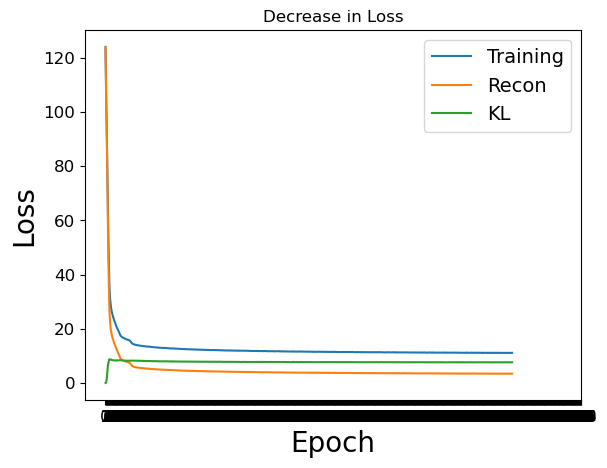

In [41]:
# plotting the decrease in loss as the network learns
fig_loss = plt.figure()
ax = fig_loss.add_subplot(111)
ax.plot(fitting_output.history['total_loss'], label='Training')
ax.plot(fitting_output.history['recon_loss'], label='Recon')
ax.plot(fitting_output.history['kl_loss'], label='KL')
ax.set_title('Decrease in Loss')
ax.set_ylabel('Loss', fontsize=20)
ax.set_xlabel('Epoch', fontsize=20)
ax.legend(loc='upper right', fontsize=14)
ax.tick_params(axis='both', which='both', labelsize=12)
ax.set_xticks(np.arange(0, epochs, 1))
#ax.set_ylim(0, 0.3)
plt.show()

## testing the model

In [42]:
# compare autoencoder model to encoder and decoder models

# f1 = autoencoder.predict(x_test)
f2 = decoder(encoder(x_test)[2])

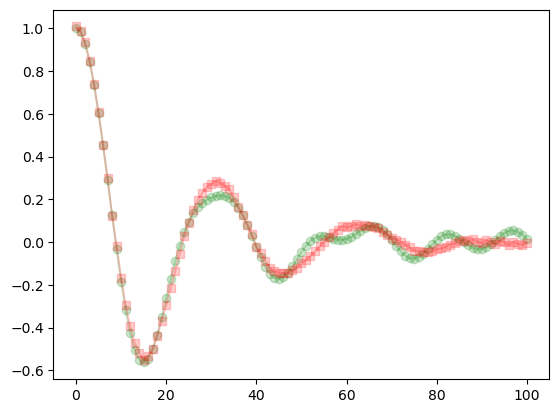

In [51]:
sample = 756

plt.plot(x_test[sample], color='g', marker='o', alpha=0.2)
# plt.plot(f1[sample], color='b', marker='*', alpha=0.2)
plt.plot(f2[sample], color='r', marker='s', alpha=0.2)

In [44]:
encoded_data = encoder.predict(x_test)[2]

63/63 [==============================] - 0s 2ms/step


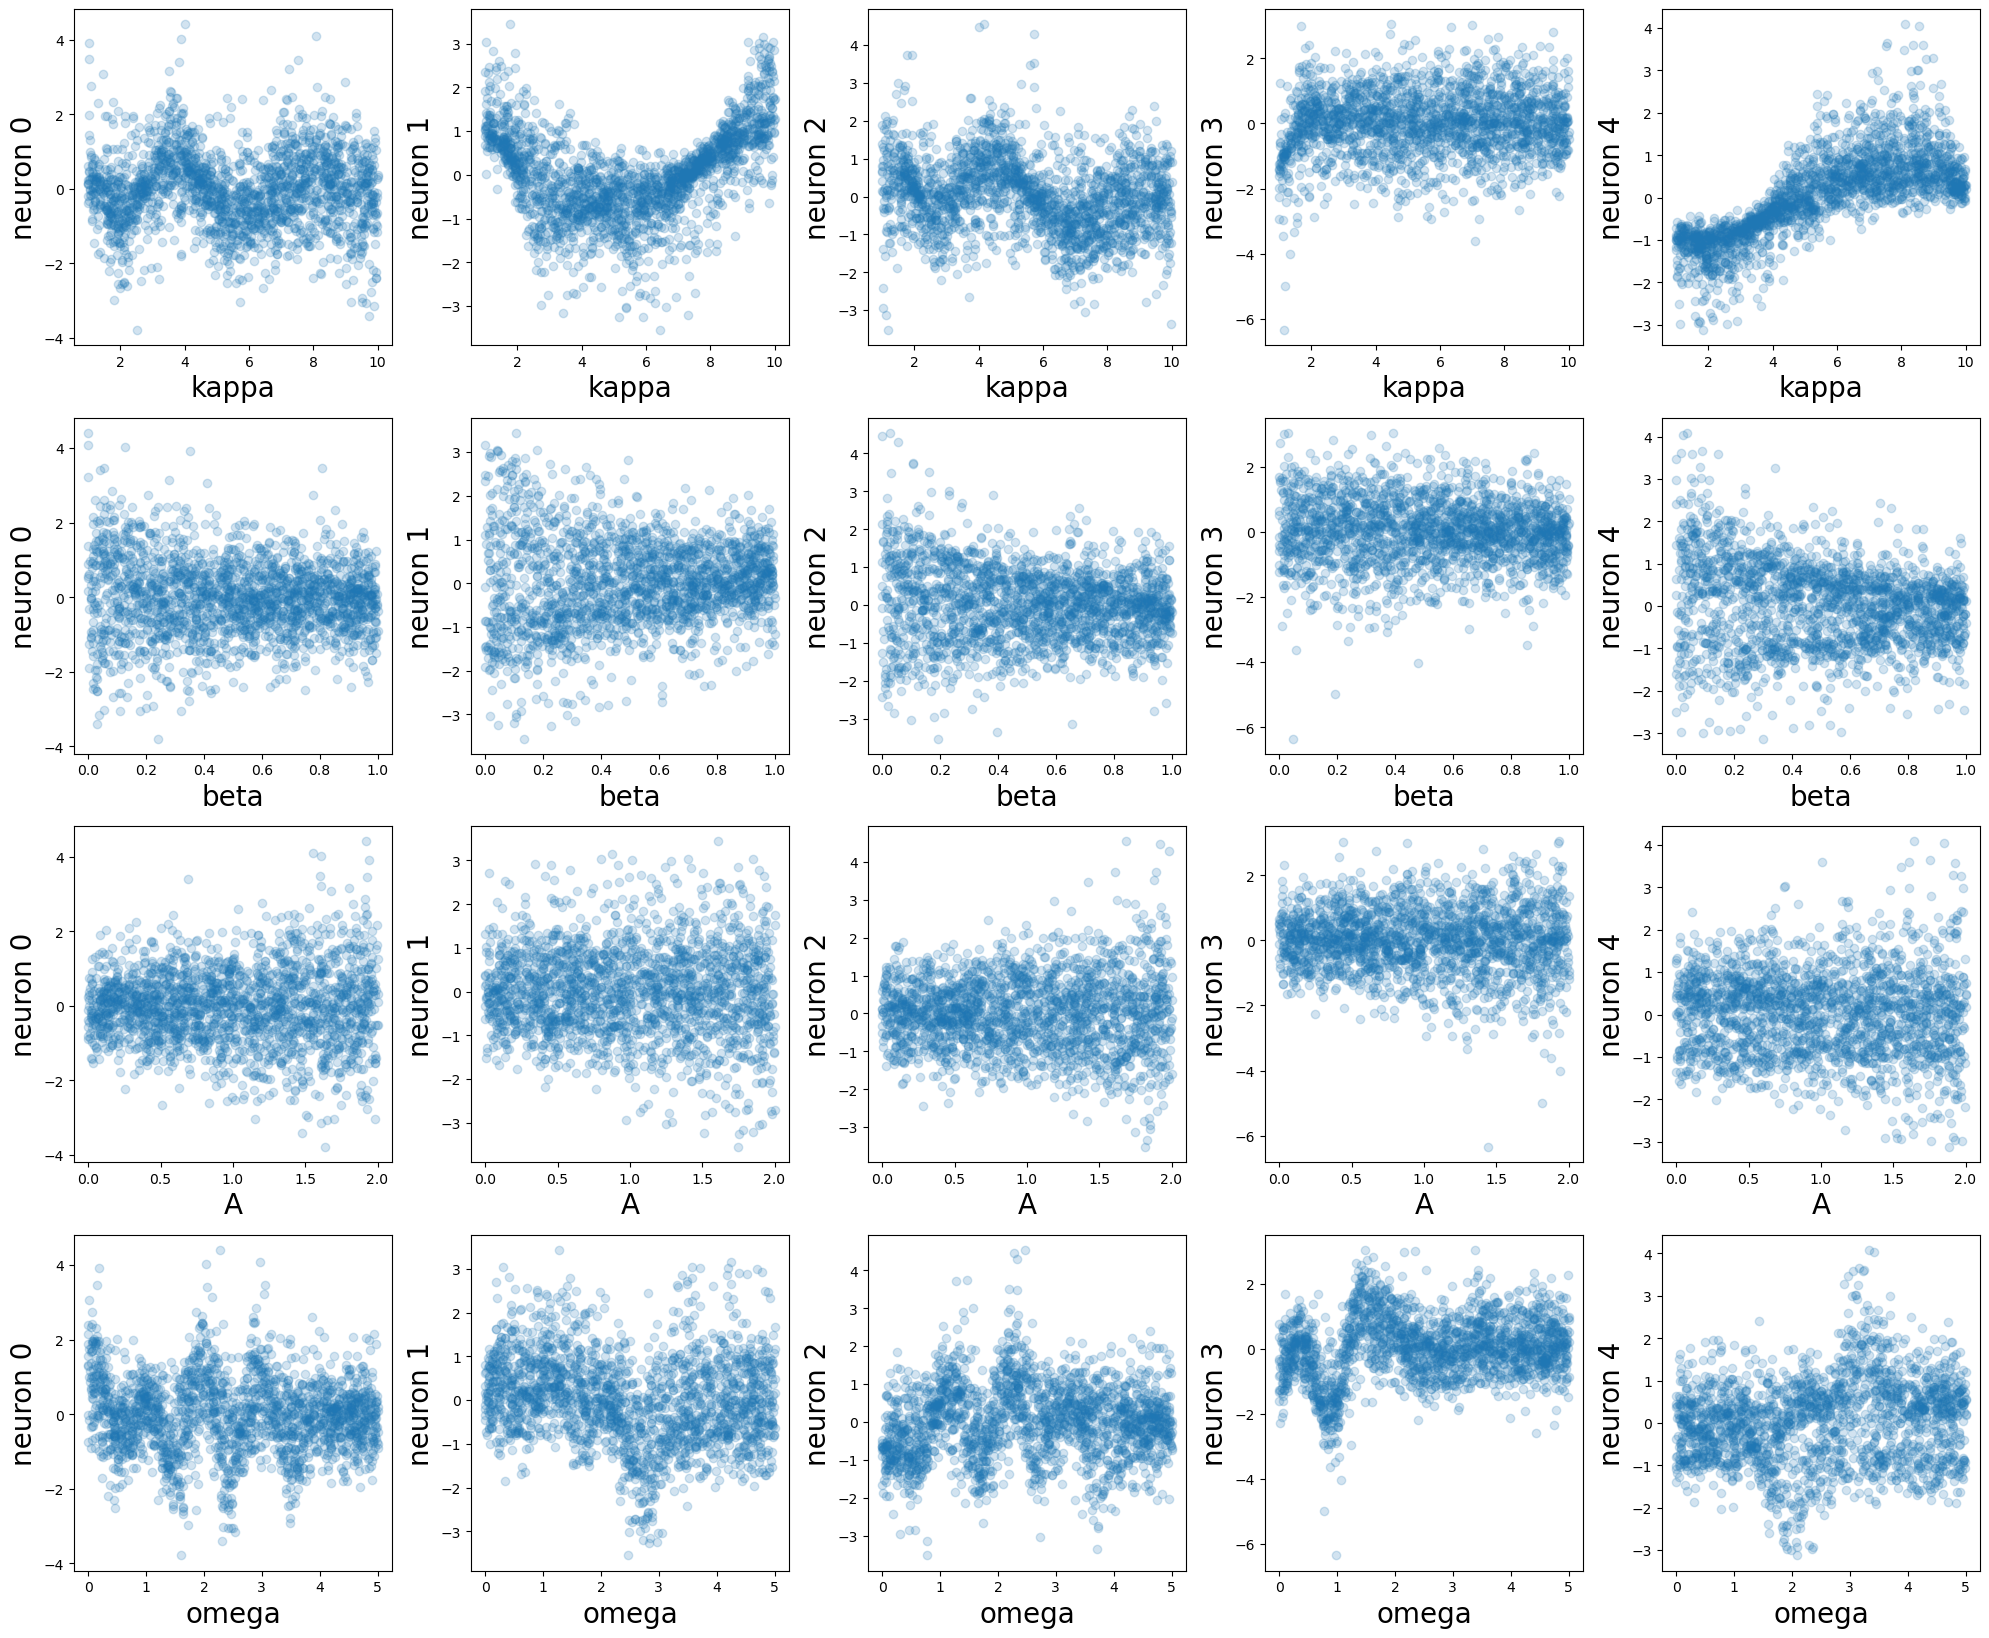

In [45]:
fig = plt.figure(figsize=(20, 20))

fontsize = 20

# Kappa plots
ax1 = fig.add_subplot(551)
ax1.plot(kappas_te, encoded_data[:, 0], 'o', alpha=0.2)
ax1.set_xlabel('kappa', fontsize=fontsize)
ax1.set_ylabel('neuron 0', fontsize=fontsize)

ax2 = fig.add_subplot(552)
ax2.plot(kappas_te, encoded_data[:, 1], 'o', alpha=0.2)
ax2.set_xlabel('kappa', fontsize=fontsize)
ax2.set_ylabel('neuron 1', fontsize=fontsize)

ax3 = fig.add_subplot(553)
ax3.plot(kappas_te, encoded_data[:, 2], 'o', alpha=0.2)
ax3.set_xlabel('kappa', fontsize=fontsize)
ax3.set_ylabel('neuron 2', fontsize=fontsize)

ax4 = fig.add_subplot(554)
ax4.plot(kappas_te, encoded_data[:, 3], 'o', alpha=0.2)
ax4.set_xlabel('kappa', fontsize=fontsize)
ax4.set_ylabel('neuron 3', fontsize=fontsize)

ax5 = fig.add_subplot(555)
ax5.plot(kappas_te, encoded_data[:, 4], 'o', alpha=0.2)
ax5.set_xlabel('kappa', fontsize=fontsize)
ax5.set_ylabel('neuron 4', fontsize=fontsize)

# Beta plots
ax6 = fig.add_subplot(556)
ax6.plot(betas_te, encoded_data[:, 0], 'o', alpha=0.2)
ax6.set_xlabel('beta', fontsize=fontsize)
ax6.set_ylabel('neuron 0', fontsize=fontsize)

ax7 = fig.add_subplot(557)
ax7.plot(betas_te, encoded_data[:, 1], 'o', alpha=0.2)
ax7.set_xlabel('beta', fontsize=fontsize)
ax7.set_ylabel('neuron 1', fontsize=fontsize)

ax8 = fig.add_subplot(558)
ax8.plot(betas_te, encoded_data[:, 2], 'o', alpha=0.2)
ax8.set_xlabel('beta', fontsize=fontsize)
ax8.set_ylabel('neuron 2', fontsize=fontsize)

ax9 = fig.add_subplot(559)
ax9.plot(betas_te, encoded_data[:, 3], 'o', alpha=0.2)
ax9.set_xlabel('beta', fontsize=fontsize)
ax9.set_ylabel('neuron 3', fontsize=fontsize)

ax10 = fig.add_subplot(5, 5, 10)
ax10.plot(betas_te, encoded_data[:, 4], 'o', alpha=0.2)
ax10.set_xlabel('beta', fontsize=fontsize)
ax10.set_ylabel('neuron 4', fontsize=fontsize)

# A plots
ax11 = fig.add_subplot(5, 5, 11)
ax11.plot(As_te, encoded_data[:, 0], 'o', alpha=0.2)
ax11.set_xlabel('A', fontsize=fontsize)
ax11.set_ylabel('neuron 0', fontsize=fontsize)

ax12 = fig.add_subplot(5, 5, 12)
ax12.plot(As_te, encoded_data[:, 1], 'o', alpha=0.2)
ax12.set_xlabel('A', fontsize=fontsize)
ax12.set_ylabel('neuron 1', fontsize=fontsize)

ax13 = fig.add_subplot(5, 5, 13)
ax13.plot(As_te, encoded_data[:, 2], 'o', alpha=0.2)
ax13.set_xlabel('A', fontsize=fontsize)
ax13.set_ylabel('neuron 2', fontsize=fontsize)

ax14 = fig.add_subplot(5, 5, 14)
ax14.plot(As_te, encoded_data[:, 3], 'o', alpha=0.2)
ax14.set_xlabel('A', fontsize=fontsize)
ax14.set_ylabel('neuron 3', fontsize=fontsize)

ax15 = fig.add_subplot(5, 5, 15)
ax15.plot(As_te, encoded_data[:, 4], 'o', alpha=0.2)
ax15.set_xlabel('A', fontsize=fontsize)
ax15.set_ylabel('neuron 4', fontsize=fontsize)

# Omega plots
ax16 = fig.add_subplot(5, 5, 16)
ax16.plot(omegas_te, encoded_data[:, 0], 'o', alpha=0.2)
ax16.set_xlabel('omega', fontsize=fontsize)
ax16.set_ylabel('neuron 0', fontsize=fontsize)

ax17 = fig.add_subplot(5, 5, 17)
ax17.plot(omegas_te, encoded_data[:, 1], 'o', alpha=0.2)
ax17.set_xlabel('omega', fontsize=fontsize)
ax17.set_ylabel('neuron 1', fontsize=fontsize)

ax18 = fig.add_subplot(5, 5, 18)
ax18.plot(omegas_te, encoded_data[:, 2], 'o', alpha=0.2)
ax18.set_xlabel('omega', fontsize=fontsize)
ax18.set_ylabel('neuron 2', fontsize=fontsize)

ax19 = fig.add_subplot(5, 5, 19)
ax19.plot(omegas_te, encoded_data[:, 3], 'o', alpha=0.2)
ax19.set_xlabel('omega', fontsize=fontsize)
ax19.set_ylabel('neuron 3', fontsize=fontsize)

ax20 = fig.add_subplot(5, 5, 20)
ax20.plot(omegas_te, encoded_data[:, 4], 'o', alpha=0.2)
ax20.set_xlabel('omega', fontsize=fontsize)
ax20.set_ylabel('neuron 4', fontsize=fontsize)

plt.tight_layout()

graphs_file_path = f"kl_b:{batch_size}_lr:{learning_rate}_r:{regul}_r2:{regul2}"
plt.savefig(f"{graphs_file_path}.png")
plt.show()
plt.close(fig)

In [18]:
from IPython.lib.display import Audio

framerate = 4410
play_time_seconds = 1
t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)
audio_data = np.sin(2*np.pi*300*t)
Audio(audio_data, rate=framerate, autoplay=True)